# Определение возраста покупателей

## Задача.

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

    Контролировать добросовестность кассиров при продаже алкоголя.

## Загрузка и анализ данных

### Загрузим библиотеки

In [1]:
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error

### Загрузим и проанализируем данные

In [2]:
path = "D:\\programs\\YA practicum\\AppaREAL"
data = pd.read_csv(path + '/labels.csv')
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


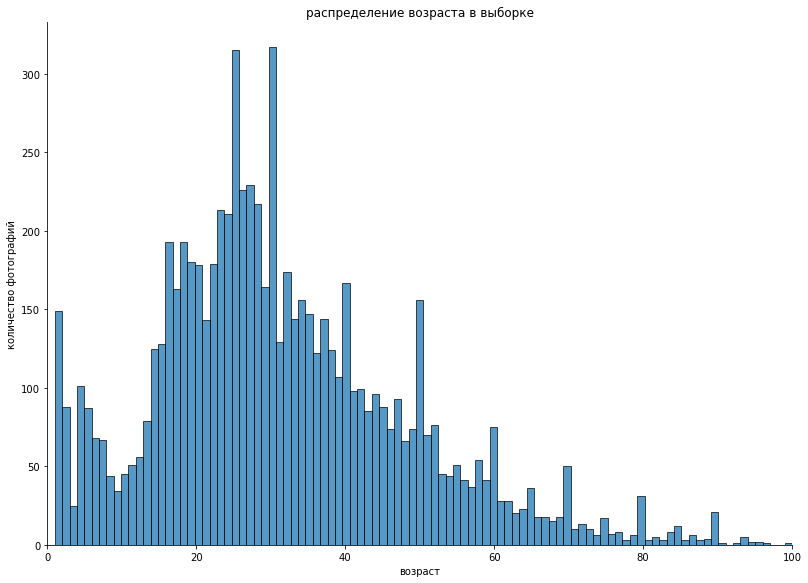

In [3]:
sns.displot(data = data['real_age'],
                   kind='hist',
                   bins = 100,
                   aspect = 1.4,
                   height = 8
                   )

    # Plot formatting
plt.title('распределение возраста в выборке')
plt.xlabel('возраст')
plt.ylabel('количество фотографий')
plt.xlim(0, 100)
plt.show()

In [4]:
# define train data generator
train_generator = ImageDataGenerator(validation_split = 0.25,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     rotation_range=90,
                                     horizontal_flip=True,
                                     rescale = 1/255).flow_from_dataframe(
                                                                            dataframe=data,
                                                                            directory=path + '/final_files',
                                                                            subset='training',
                                                                            x_col= 'file_name',
                                                                            y_col= 'real_age',
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            seed=12345,
                                                                            class_mode='raw'
                                                                            )

Found 5694 validated image filenames.


In [5]:
# функция загрузки тестовых данных
test_generator = ImageDataGenerator(validation_split = 0.25,
                                       rescale = 1/255).flow_from_dataframe(
                                                                            dataframe=data,
                                                                            directory=path + '/final_files',
                                                                            subset='validation',
                                                                            x_col= 'file_name',
                                                                            y_col= 'real_age',
                                                                            target_size=(224, 224),
                                                                            batch_size=(data['real_age'].count() - len(train_generator)),
                                                                            seed=12345,
                                                                            class_mode='raw'
                                                                            )

Found 1897 validated image filenames.


### Посмотрим фотографии

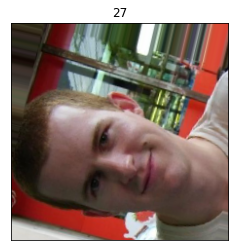

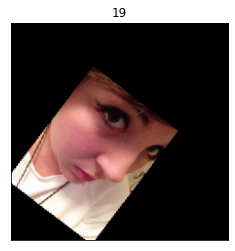

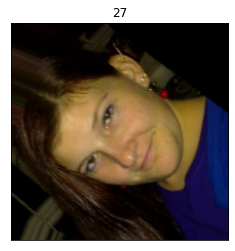

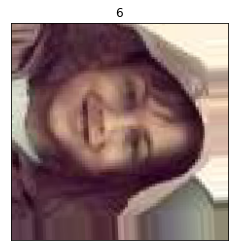

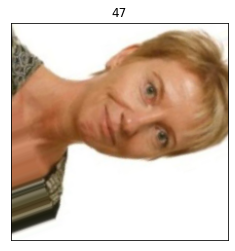

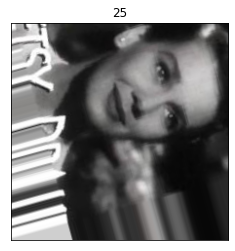

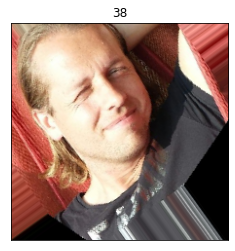

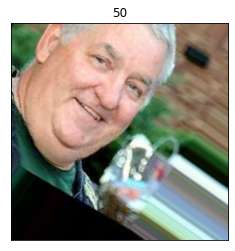

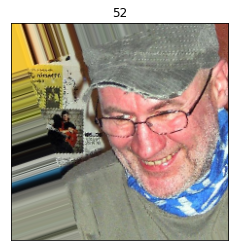

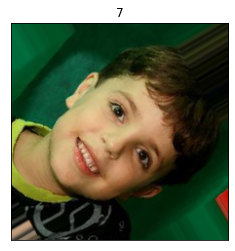

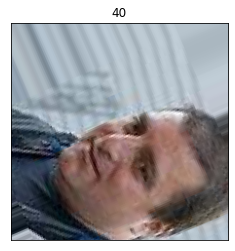

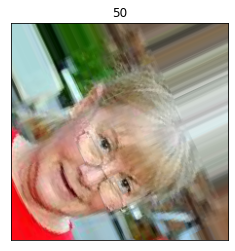

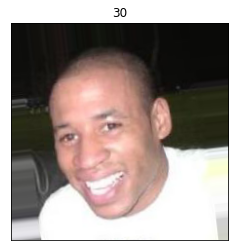

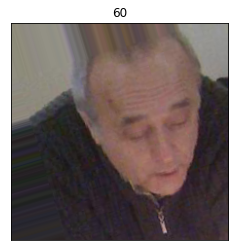

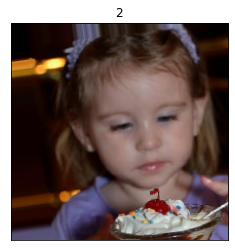

In [6]:
images, ages = next(train_generator)
for i in range (0,15):
    array = np.array(train_generator[0][0][i])
    plt.title(ages[i])
    plt.imshow(array)
    plt.grid ( False )
    plt.xticks([])
    plt.yticks([])
    plt.show()

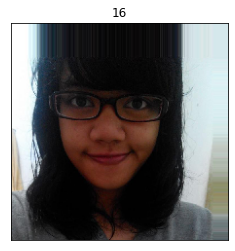

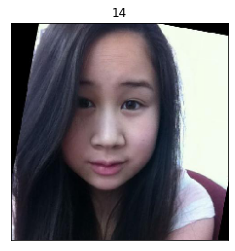

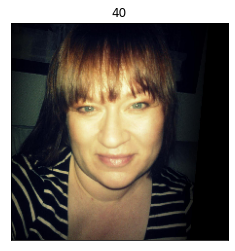

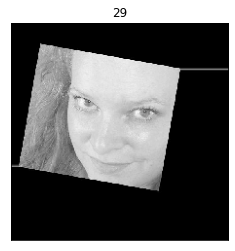

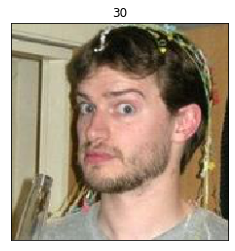

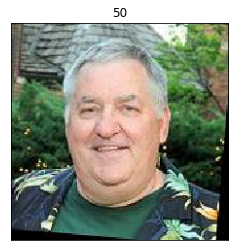

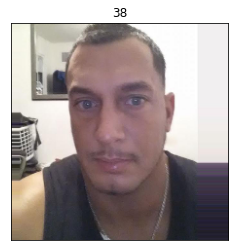

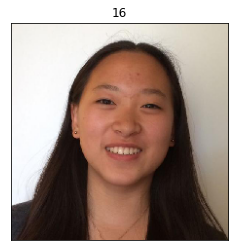

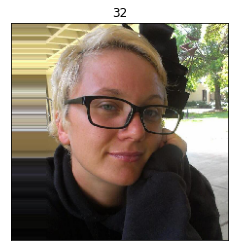

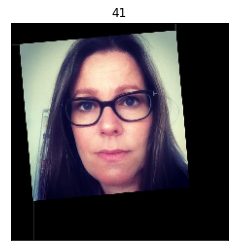

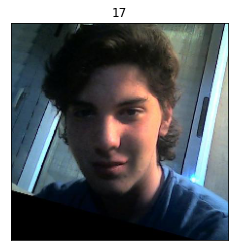

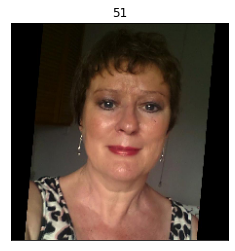

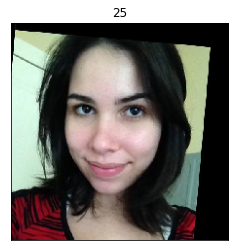

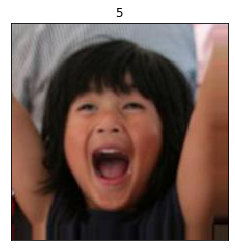

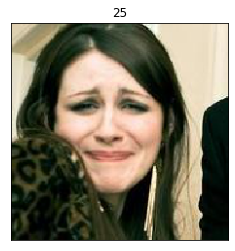

In [7]:
images, ages = next(test_generator)
for i in range (0,15):
    array = images[i]
    plt.title(ages[i])
    plt.imshow(array)
    plt.grid ( False )
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Промежуточный вывод: 
    Данные состоят из 7591 фотографии с лицами людей разных возрастов.
    Распределение возрастов нормальное, данные подходят для обучения.
    не много фотографий детей в районе 10 лет, так же заметны выбросы на круглых возрастах 20, 30, 40, 50, 60, 70, 80 и 90 лет.
    

## Создадим  и обучим модель

### Для удобства создадим фукнции

In [8]:
# функция создания модели
def create_model(input_shape):
    optimizer = Adam(learning_rate = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    classes = 1000,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))                
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

    return model

In [9]:
# функция обучения модели
def train_model(model, train_data, test_data, batch_size, epochs,
            steps_per_epoch, validation_steps):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

### Создадим и обучим модель по функциям

In [10]:
resnet50 = create_model((224, 224, 3))

In [12]:
train_model(resnet50, train_generator, test_generator, 32, 10,
                None, None)

Epoch 1/10
178/178 - 1235s - loss: 305.9331 - mse: 305.9331 - val_loss: 553.1288 - val_mse: 553.1288 - 1235s/epoch - 7s/step
Epoch 2/10
178/178 - 1214s - loss: 138.0111 - mse: 138.0111 - val_loss: 566.4467 - val_mse: 566.4467 - 1214s/epoch - 7s/step
Epoch 3/10
178/178 - 1206s - loss: 116.6942 - mse: 116.6942 - val_loss: 429.1379 - val_mse: 429.1379 - 1206s/epoch - 7s/step
Epoch 4/10
178/178 - 1024s - loss: 103.3983 - mse: 103.3983 - val_loss: 141.4375 - val_mse: 141.4375 - 1024s/epoch - 6s/step
Epoch 5/10
178/178 - 1028s - loss: 91.6887 - mse: 91.6887 - val_loss: 95.1662 - val_mse: 95.1662 - 1028s/epoch - 6s/step
Epoch 6/10
178/178 - 1027s - loss: 90.9116 - mse: 90.9116 - val_loss: 123.6814 - val_mse: 123.6814 - 1027s/epoch - 6s/step
Epoch 7/10
178/178 - 1022s - loss: 84.7122 - mse: 84.7122 - val_loss: 96.1786 - val_mse: 96.1786 - 1022s/epoch - 6s/step
Epoch 8/10
178/178 - 1024s - loss: 79.1060 - mse: 79.1060 - val_loss: 83.1011 - val_mse: 83.1011 - 1024s/epoch - 6s/step
Epoch 9/10
178

## Проведем предсказания для сохраненной и загруженной моделей

### Получим возраст из тестовых данных

In [15]:
test_pics, test_ages = next(test_generator)

In [16]:
print(len(test_ages))
print('возраст из тестовой выборки', test_ages)

1897
возраст из тестовой выборки [23 40 27 ...  5 22 45]


### Проведем предсказания полученной модели

In [17]:
# Предскажем по созданной модели
resnet50_predictions = resnet50.predict(test_generator)
print(len(resnet50_predictions))
print(resnet50_predictions)

1/1 [==============================] - 135s 135s/step
1897
[[24.414968 ]
 [45.76309  ]
 [35.356228 ]
 ...
 [ 6.1141696]
 [27.762499 ]
 [31.362068 ]]


In [20]:
mae = mean_absolute_error(test_ages, resnet50_predictions)
print('Ошибка обученной модели составила', mae)

Ошибка обученной модели составила 6.726204458119433


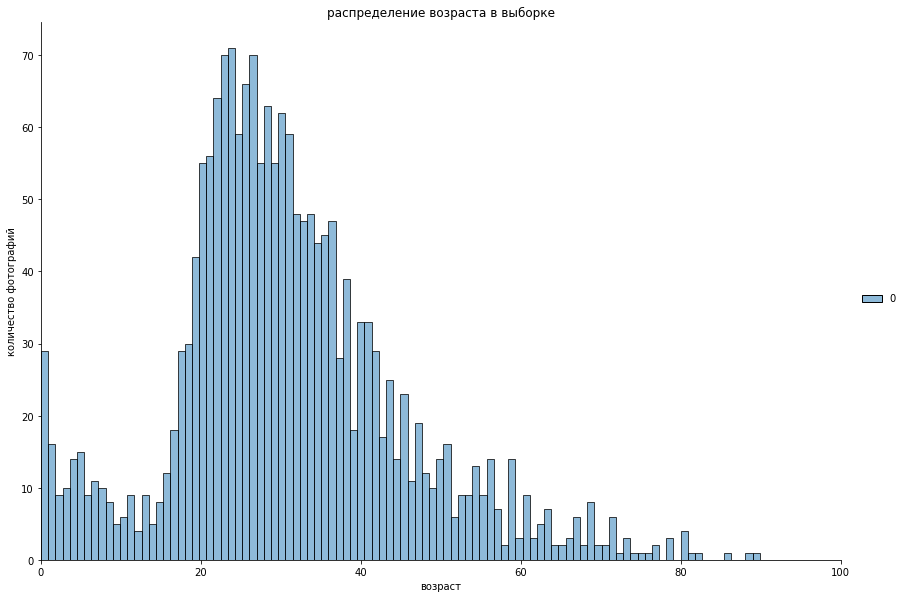

In [34]:
sns.displot(data=resnet50_predictions,
            kind='hist',
            bins=100,
            aspect=1.5,
            height=8)
# Plot formatting
plt.title('распределение возраста в выборке')
plt.xlabel('возраст')
plt.ylabel('количество фотографий')
plt.xlim(0, 100)
plt.show()

### Сохраним модель, загрузим и проверим ее

In [41]:
resnet50.save('saved_model/RESNET50_trained.h5')

In [42]:
resne50_loaded = tf.keras.models.load_model('saved_model/RESNET50_trained.h5')

In [43]:
loaded_predict = resne50_loaded.predict(test_pics)

60/60 [==============================] - 83s 1s/step


In [44]:
print(loaded_predict)
print(mean_absolute_error(test_ages, loaded_predict))

[[24.414967]
 [45.76309 ]
 [35.356224]
 ...
 [ 6.114169]
 [27.762499]
 [31.362068]]
6.726204386512166


## Заключение

1. Для предсказания возраста по фотографии были предоставлены 7591 фотография людей разных возрастов.

        Распределение возрастов нормальное, данные подходят для обучения.
        Есть выбросы на круглых цифрах, блольше фотографий в возрасте 20, 30, 40, 50, 60, 70, 80 и 90 лет.

2. Для предсказания была выбрана модель Resnet50.
3. Предсказания проводились в 10 эпох, абсолютная ошибка составила 6,7 года.

        Модель сохранена для использования.